In [1]:
pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.


# Parte 1 - Preprocesado de los datos

# Importación de las librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importar el dataset de entrenamiento

In [6]:
dataset_train = pd.read_csv("./Google_Stock_Price_Train.csv")
# Utilizamos el slice 1:2 en lugar de poner solo 1 para que no nos lo convierta a un vector.
training_set  = dataset_train.iloc[:, 1:2].values

# Escalado de características

In [7]:
# En las redes neuronales recurrentes es recomendable utilizar la normalización en lugar de la estandarización. El proceso de convergencia es mejor.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Crear una estructura de datos con 60 timesteps y 1 salida

In [23]:
# Esta estructura es necesaria para entrenar la red neuronal recurrente.
# 60 timesteps: en cada momento del tiempo la red será capaz de mirar 60 días atrás y en base a eso predecir el precio del día siguiente. Hay 20 días financieros por mes.
# Estamos prediciendo en base al trimestre.
# Desde el día el 1 hasta el 60 se utilizan para predecir el 61, del 2 al 61 se usan para predecir el 62 y así sucesivamente
X_train = []
y_train = []
timesteps = 60
for i in range(timesteps, training_set.shape[0]):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Redimensión de los datos

In [79]:
# Agregamos una nueva dimensión para hacer más robusta la predicción. Podríamos tener otros datos de otras compañías, otros valores de acciones...Estos datos irían en la dimensión de profundidad.
#   - Esta dimensión, llamada "la unidad" permite identificar la cantidad de variables predictoras que se van a utilizar.
#   - Ahora solo tenemos un indicador, precio de la acción de Google a la apertura.
#   - Con la nueva dimensión podríamos añadir más indicadores.
#   - La red recurrente de keras espera un tensor 3D con la forma (batch_size, timesteps, input_dim).
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Esto vendría a ser equivalente a lo de arriba, se puede poner -1 para que deje una dimensión como está pero solo se puede poner 1.
# X_train = X_train.reshape(-1, -1, 1)

# Parte 2 - Construcción de la RNR

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [27]:
regressor = Sequential()

# Añadir la primera capa de LSTM y la regulariación por Dropout

In [28]:
# - units: cuantas neuronas queremos en esta capa. Deberá ser un número alto, añadiremos una elevada dimensionalidad para que se capturen correlaciones a un nivel complejo.
# - return_sequences: true si queremos un LSTM apilado (tener varias capas de LSTM, haciendo un modelo más robusto). La última capa de LSTM tendrá return_sequences a false
# - input_shape: tamaño de la forma de entrada de los datos. La red no entrenará con todas las observaciones de golpe y se podrá hacer uno a uno, en bloques...
#                Lo que la red debe saber son los timesteps y el número de features o variables predictores.
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]) ))
# Para el dropout en LSTM utilizamos un valor algo más alto.
regressor.add(Dropout(0.2))

# Añadir la segunda capa de LSTM y la regulariación por Dropout

In [29]:
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la tercera capa de LSTM y la regulariación por Dropout

In [30]:
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la cuarta capa de LSTM y la regulariación por Dropout


In [31]:
# Aquí no hace falta el return _sequences ya que es la última.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Añadir la capa de salida

In [32]:
regressor.add(Dense(units = 1))

# Compilar la RNR
# Como va a ser entrenada?

In [33]:
# En cuanto al optimizador la documentación de Keras se indica que para clasificaciones se suele utilizar RMSprop, también para RNR.
# Sin embargo tras las pruebas se observa que da mejores resultados el optimizador de adam, así que se utilizará ese.
# Utilizamos otra función de costes debido a que estamos en otro problema distinto, estamos haciendo regresión en lugar de clasificación.
# Vamos a minimizar el error entre el valor de la predicción y el valor del dato.
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Ajustar la RNR al conjunto de entrenamiento

In [34]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 11s 68ms/step - loss: 0.0493
Epoch 2/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0069
Epoch 3/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0068
Epoch 4/100
38/38 [==============================] - 2s 64ms/step - loss: 0.0061
Epoch 5/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0051
Epoch 6/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 2s 64ms/step - loss: 0.0052
Epoch 9/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0045
Epoch 10/100
38/38 [==============================] - 3s 67ms/step - loss: 0.0045
Epoch 11/100
38/38 [==============================] - 2s 64ms/step - loss: 0.0044
Epoch 12/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0042
Epoch 13/100
38/38 [====

# Parte 3 - Ajustar las predicciones y visualizar los resultados

# Obtener el valor de las acciones reales  de Enero de 2017

In [35]:
dataset_test = pd.read_csv('./Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values


# Obtener la predicción de la acción con la RNR para Enero de 2017

1/1 [==============================] - 0s 52ms/step


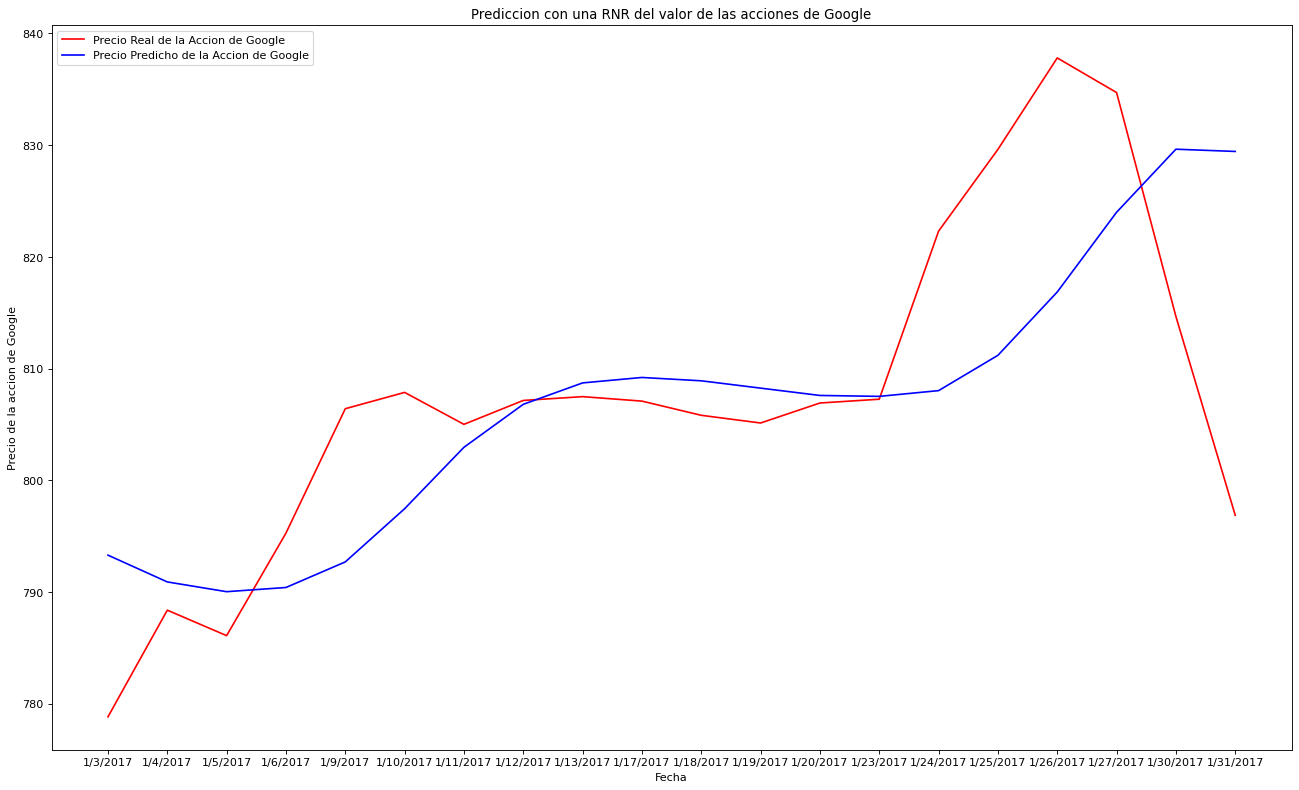

In [74]:
# Ahora tenemos los 60 días anteriores a enero en el conjunto de entrenamiento, tendremos que concatenar ambos conjuntos.
dataset_total = pd.concat((dataset_train.Open, dataset_test.Open), axis = 0)
# Nos quedaremos desde el final del dataset total (len(dataset_total)), menos los 20 días de enero (longitud de dataset de test o len(dataset_test)), menos los 60 días para atrás que necesitamos
# Necesitamos irnos hasta el final del dataset así que pondremos los dos puntos.
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# Hacemos nuevamente el reshape para añadir la dimensión que necesita la red neuronal.
inputs = inputs.reshape(-1,1)
# Haremos el escalado sobre la concatenación ya que así todos se someterán al mismo factor de escala. Puede haber valores que superen el 1, los que sean más grandes que el máximo.
inputs = sc.transform(inputs)

# Construimos la misma estructura de datos que en el entrenamiento
X_test = []
# Código original
# for i in range(60, 80):
#     X_test.append(inputs[i-60:i, 0])
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizamos la predicción
predicted_stock_price = regressor.predict(X_test)
# Tenemos que desescalar los datos para poderlos interpretar con "inverse_transform"
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizar los Resultados
plt.figure(figsize=(20, 12), dpi=80)
plt.plot(real_stock_price, color = 'red', label = 'Precio Real de la Accion de Google')
plt.plot(predicted_stock_price, color = 'blue', label = 'Precio Predicho de la Accion de Google')
dates = dataset_test.Date.values
plt.xticks(range(0, len(dates)), dates)
plt.title("Prediccion con una RNR del valor de las acciones de Google")
plt.xlabel("Fecha")
plt.ylabel("Precio de la accion de Google")
plt.legend()
plt.show()

# Evaluar la RNR

Hola estudiante,

Como se ven en los vídeos de las clases prácticas, las RNR que hemos construido han sido de regresión. De hecho, estábamos lidiando con la regresión porque estábamos tratando de predecir un resultado continuo (el precio de las acciones de Google). Para la regresión, la forma de evaluar el rendimiento del modelo es con una métrica llamada RMSE (root mean square error o bien error cuadrático medio). Se calcula como la raíz de la media de las diferencias al cuadrado entre las predicciones y los valores reales como ya vimos en el curso de Machine Learning de la A a la Z.

Sin embargo, para nuestro problema específico de predicción del precio de las acciones, evaluar el modelo con el RMSE no tiene mucho sentido, ya que estamos más interesados ​​en las direcciones tomadas por nuestras predicciones, en lugar de la cercanía de sus valores al precio real de las acciones. Queremos verificar si nuestras predicciones siguen las mismas direcciones que las del precio real de las acciones y realmente no nos importa si nuestras predicciones están cerca del precio real de las mismas. Las predicciones podrían ser cercanas, pero a menudo toman la dirección opuesta al precio real de las acciones, con lo cual perdemos dinero...

Sin embargo, si estás interesado en el código que calcula el RMSE para nuestro problema de predicción del precio de las acciones, te lo dejo aquí a continuación:

Luego considera dividir este RMSE por el rango de los valores del precio de las acciones de Google del mes de enero de 2017 (alrededor de 800) para obtener un error relativo, en lugar de un error absoluto. Es más relevante ya que, por ejemplo, si obtenemos un RMSE de 50, este error sería muy grande si los valores del precio de las acciones oscilaran alrededor de 100, pero sería muy pequeño si los valores del precio de las acciones oscilaran alrededor de 10000.

¡Disfruta del aprendizaje profundo!

In [78]:
import math
from sklearn.metrics import mean_squared_error
from statistics import mean

rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
mean_stock_prices = mean(real_stock_price[0])
print(rmse / mean_stock_prices)

0.015635585074939895


# Mejorar la RNR

Hola estudiantes,

Aquí hay diferentes maneras de mejorar el modelo de RNR:

- Obteniendo más datos de entrenamiento: entrenamos a nuestro modelo con los últimos 5 años del precio de las acciones de Google, pero sería aún mejor entrenarlo con los datos de los últimos 10 años.

- Aumento del número de timesteps: el modelo recordó los precios de las acciones de los 60 días financieros anteriores para predecir el precio de las acciones del día siguiente. Esto se debe a que elegimos un timestep de 60 pasos (3 meses). Puedes intentar aumentar el número de pasos de tiempo, eligiendo, por ejemplo, un timestep de 120 pasos (6 meses).

- Agregar algunos otros indicadores: si tienes el instinto financiero de que el precio de las acciones de otras compañías podría estar correlacionado con el de Google, podrías agregar este otro precio de las acciones como un nuevo indicador en los datos de entrenamiento (como hacen los brokers de verdad).

- Agregar más capas LSTM: hemos creamos una RNR con cuatro capas LSTM, pero podrías probar con aún más capas.

- Agregando más neuronas en las capas LSTM: hemos visto que necesitábamos una gran cantidad de neuronas en las capas LSTM para responder mejor a la complejidad del problema y en nuestro caso hemos elegimos incluir 50 neuronas en cada una de nuestras 4 capas LSTM. Puedes probar una arquitectura con aún más neuronas en cada una de las 4 (o más) capas LSTM.

¡Disfruta del aprendizaje profundo!

# Ajustar la RNR

Hola estudiante,

Puedes hacer algunos ajustes de parámetros en el modelo de RNR que hemos implementado.

Recuerda, esta vez estamos lidiando con un problema de regresión porque predecimos un resultado continuo (el precio de las acciones de Google).

El ajuste de parámetros para la regresión es el mismo que el ajuste de parámetros para la clasificación que aprendimos juntos en la Parte 1 - Redes neuronales artificiales, la única diferencia es que tienes que reemplazar:

```
scoring = 'accuracy'
```

por:

```
scoring = 'neg_mean_squared_error'
```

(en el mean_squared_error cuanto más pequeña es la medida mejor...se utiliza como medida la negada para que cuanto mayor sea el valor sea mejor)
en los parámetros de la clase GridSearchCV.

¡Disfruta del aprendizaje profundo!